In [1]:
!pip install pandas matplotlib seaborn scikit-learn scipy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

In [3]:
#Load Data

df = pd.read_csv("molecules_lc_ms.csv", encoding='latin1')  # Replace with your actual filename and specify encoding

features = ['DeltaMass', 'MW', 'm/z', 'RT']
X = df[features].values
names = df['Name']
classes = df['Class of compounds'].astype('category')

In [4]:
# 2. Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

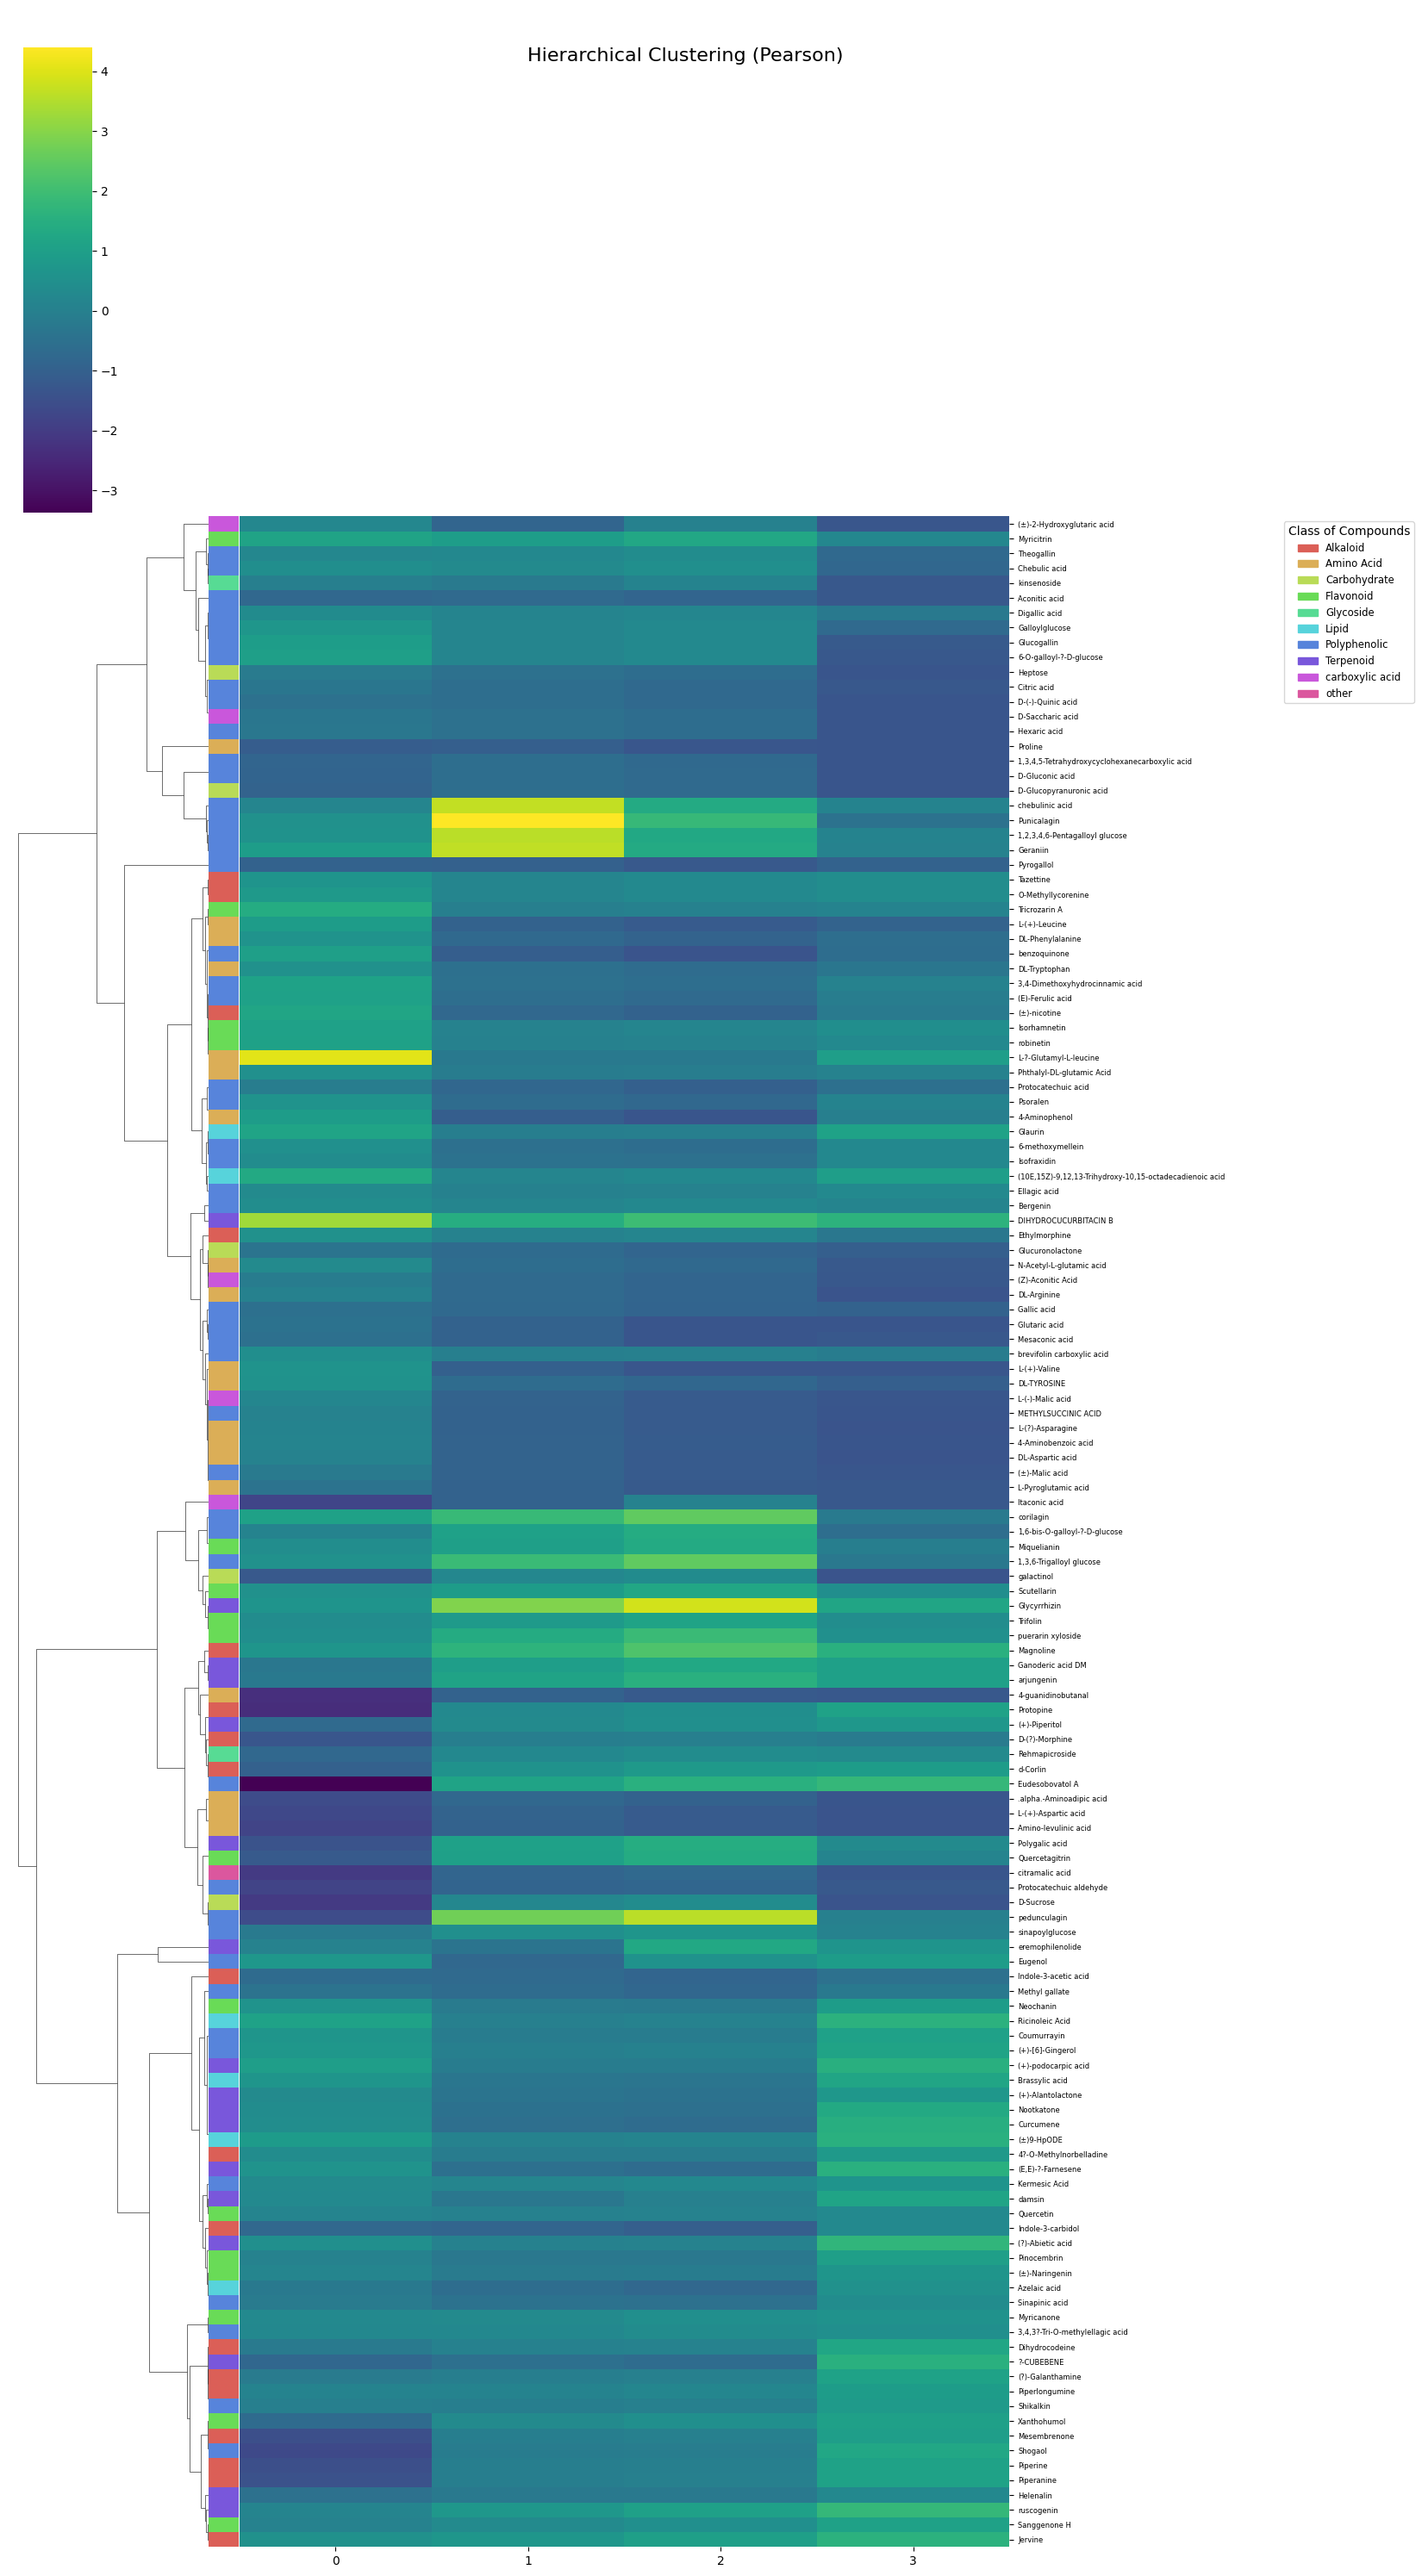

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

# Step 1: Pearson correlation distance matrix (feature-wise)
corr = np.corrcoef(X_scaled.T)
distance_matrix = 1 - corr
linkage_matrix = linkage(squareform(distance_matrix), method='average')

# Step 2: Map classes to colors
palette = sns.color_palette("hls", len(classes.cat.categories))
color_dict = dict(zip(classes.cat.categories, palette))
df['row_colors'] = df['Class of compounds'].map(color_dict)

# Step 3: Generate clustermap
g = sns.clustermap(
    X_scaled,
    metric='correlation',
    method='average',
    row_cluster=True,
    col_cluster=False,
    row_colors=df['row_colors'].to_numpy(),
    yticklabels=names,
    figsize=(16, 30),
    cmap='viridis'
)

# Step 4: Format plot
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=6)
g.fig.suptitle("Hierarchical Clustering (Pearson)", fontsize=16)

# Step 5: Add legend
handles = [mpatches.Patch(color=color_dict[class_name], label=class_name)
           for class_name in color_dict]
g.ax_heatmap.legend(
    handles=handles,
    title='Class of Compounds',
    bbox_to_anchor=(1.35, 1),
    loc='upper left',
    frameon=True,
    fontsize='small',
    title_fontsize='medium'
)

# Step 6: Save figure at 600 DPI
g.savefig("hierarchical_clustering_pearson.png", dpi=600, bbox_inches='tight')

# Optional: Show plot (in case you're not in headless mode)
plt.show()

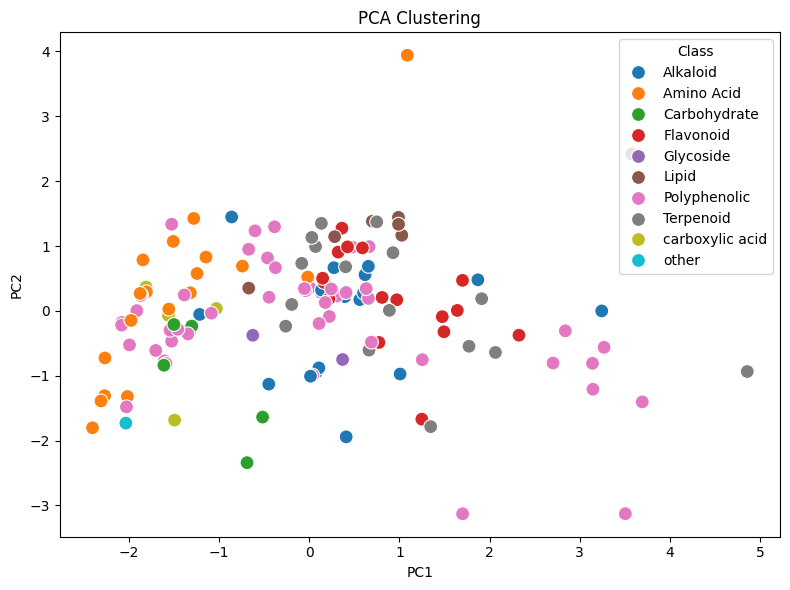

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# Step 1: Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Create a dataframe for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Name"] = names
pca_df["Class"] = classes

# Step 3: Plot PCA scatter and save
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Class", s=100)
plt.title("PCA Clustering")
plt.tight_layout()
plt.savefig("pca_clustering.png", dpi=600, bbox_inches='tight')  # <-- Save in 600 DPI
plt.show()

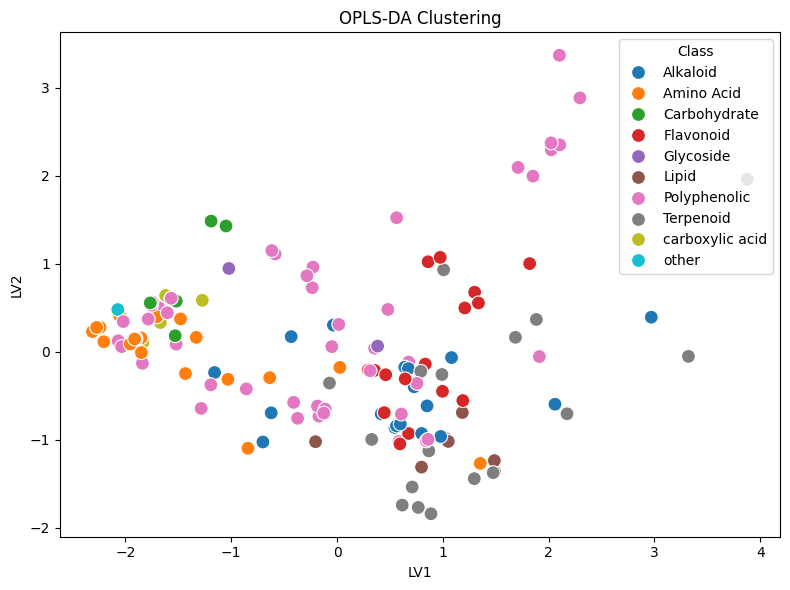

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
import pandas as pd

# Step 1: One-hot encode classes
Y = pd.get_dummies(classes)

# Step 2: Fit PLSRegression (OPLS-DA style)
pls = PLSRegression(n_components=2)
pls.fit(X_scaled, Y)
X_pls = pls.transform(X_scaled)

# Step 3: Prepare dataframe
opls_df = pd.DataFrame(X_pls, columns=["LV1", "LV2"])
opls_df["Name"] = names
opls_df["Class"] = classes

# Step 4: Plot and save
plt.figure(figsize=(8, 6))
sns.scatterplot(data=opls_df, x="LV1", y="LV2", hue="Class", s=100)
plt.title("OPLS-DA Clustering")
plt.tight_layout()
plt.savefig("oplsda_clustering.png", dpi=600, bbox_inches='tight')  # Save at 600 DPI
plt.show()

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cross_decomposition import PLSRegression
import numpy as np
import pandas as pd

# --- Clustering Molecules with KMeans for Silhouette Scoring ---
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)
silhouette_vals = silhouette_samples(X_scaled, labels)
silhouette_avg = silhouette_score(X_scaled, labels)

# Add results to dataframe
df['Cluster'] = labels
df['SilhouetteScore'] = silhouette_vals

print(f"Average Silhouette Score: {silhouette_avg:.2f}")

Average Silhouette Score: 0.31


In [ ]:
# --- VIP Score Calculation from OPLS-DA ---
def calculate_vip(pls_model, X):
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_
    p, h = w.shape
    vip = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([(w[i, j] ** 2) * s[j] for j in range(h)])
        vip[i] = np.sqrt(X.shape[1] * np.sum(weight) / total_s)
    return vip

In [ ]:
# Calculate VIP
pls = PLSRegression(n_components=2)
pls.fit(X_scaled, pd.get_dummies(classes))
vip_scores = calculate_vip(pls, X_scaled)

# Create VIP dataframe
vip_df = pd.DataFrame({
    'Feature': ['DeltaMass', 'MW', 'm/z', 'RT'],
    'VIP_Score': vip_scores
})
print("\nVIP Scores:")
print(vip_df)


VIP Scores:
     Feature  VIP_Score
0  DeltaMass   0.307646
1         MW   0.951275
2        m/z   0.952753
3         RT   1.446614


In [ ]:
significant_df = df[df['SilhouetteScore'] > 0.25]  # or another threshold

# Save significant clustering output
significant_df.to_csv("Significant_Molecules_Clustered.csv", index=False)
vip_df.to_csv("VIP_Scores_OPLSDA.csv", index=False)

Average Silhouette Score for Hierarchical Clustering: 0.426


/tmp/ipython-input-9-3246695045.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['HC_Cluster'], y=df['HC_Silhouette'], palette="Set2")


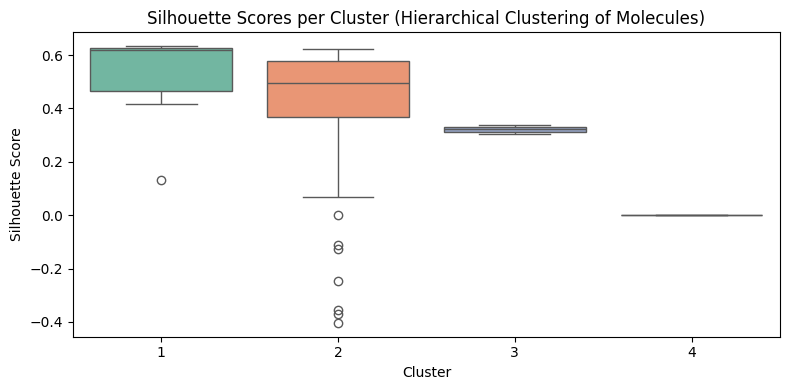

In [9]:
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Perform hierarchical clustering
hc_linkage_matrix = linkage(X_scaled, method='average')

# Step 2: Cut dendrogram into n clusters
n_clusters = 4
hc_labels = fcluster(hc_linkage_matrix, t=n_clusters, criterion='maxclust')

# Step 3: Compute silhouette scores
hc_silhouette = silhouette_samples(X_scaled, hc_labels)
hc_silhouette_avg = silhouette_score(X_scaled, hc_labels)

# Step 4: Add to dataframe
df['HC_Cluster'] = hc_labels
df['HC_Silhouette'] = hc_silhouette

print(f"Average Silhouette Score for Hierarchical Clustering: {hc_silhouette_avg:.3f}")

# Step 5: Plot and save
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['HC_Cluster'], y=df['HC_Silhouette'], palette="Set2")
plt.title("Silhouette Scores per Cluster (Hierarchical Clustering of Molecules)")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.savefig("hc_silhouette_scores.png", dpi=600, bbox_inches='tight')  # Save at 600 DPI
plt.show()

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Cluster PCA-reduced data
n_clusters = 4  # You can adjust this
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
pca_labels = kmeans_pca.fit_predict(X_pca)

# Step 2: Silhouette scores
pca_silhouette = silhouette_samples(X_pca, pca_labels)
pca_silhouette_avg = silhouette_score(X_pca, pca_labels)

# Step 3: Store results
pca_df['PCA_Cluster'] = pca_labels
pca_df['PCA_Silhouette'] = pca_silhouette

print(f"Average Silhouette Score for PCA-based Clustering: {pca_silhouette_avg:.3f}")

# Step 4: Plot and save
plt.figure(figsize=(8, 4))
sns.boxplot(x=pca_df['PCA_Cluster'], y=pca_df['PCA_Silhouette'], palette="Set2")
plt.title("Silhouette Scores per PCA Cluster")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.savefig("pca_silhouette_scores.png", dpi=600, bbox_inches='tight')  # Save in 600 DPI
plt.show()

Average Silhouette Score for PCA-based Clustering: 0.445


/tmp/ipython-input-10-3042507157.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pca_df['PCA_Cluster'], y=pca_df['PCA_Silhouette'], palette="Set2")


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Cluster in OPLS-DA space
X_opls = pls.transform(X_scaled)
n_clusters = 4  # Adjust as needed
kmeans_opls = KMeans(n_clusters=n_clusters, random_state=42)
opls_labels = kmeans_opls.fit_predict(X_opls)

# Step 2: Silhouette scores
opls_silhouette = silhouette_samples(X_opls, opls_labels)
opls_silhouette_avg = silhouette_score(X_opls, opls_labels)

# Step 3: Store results
opls_df = pd.DataFrame(X_opls, columns=["LV1", "LV2"])
opls_df["Class"] = classes
opls_df["Name"] = names
opls_df["OPLS_Cluster"] = opls_labels
opls_df["OPLS_Silhouette"] = opls_silhouette

print(f"Average Silhouette Score for OPLS-DA Clustering: {opls_silhouette_avg:.3f}")

# Step 4: Plot and save
plt.figure(figsize=(8, 4))
sns.boxplot(x=opls_df['OPLS_Cluster'], y=opls_df['OPLS_Silhouette'], palette="Set2")
plt.title("Silhouette Scores per OPLS-DA Cluster")
plt.xlabel("Cluster")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.savefig("oplsda_silhouette_scores.png", dpi=600, bbox_inches='tight')  # Save at 600 DPI
plt.show()

Average Silhouette Score for OPLS-DA Clustering: 0.437


/tmp/ipython-input-11-2954990883.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=opls_df['OPLS_Cluster'], y=opls_df['OPLS_Silhouette'], palette="Set2")


In [14]:
# Add PCA clustering results
df['PCA_Silhouette'] = pca_df['PCA_Silhouette'].values
df['PCA_Cluster'] = pca_df['PCA_Cluster'].values

# Add OPLS-DA clustering results
df['OPLS_Silhouette'] = opls_df['OPLS_Silhouette'].values
df['OPLS_Cluster'] = opls_df['OPLS_Cluster'].values

In [21]:
# Step 1: Choose which OPLS_Cluster to keep
# Assuming both _x and _y are identical, we keep _x
# df['OPLS_Cluster'] = df['OPLS_Cluster_x'] # This line is removed as it caused the error

# Step 2: Drop redundant columns
# df.drop(columns=['Cluster', 'OPLS_Cluster_x', 'OPLS_Cluster_y'], errors='ignore', inplace=True) # This line is removed as the columns don't exist

# Step 3: (Optional) Rename clustering columns consistently
df.rename(columns={
    'HC_Cluster': 'Cluster_HC',
    'PCA_Cluster': 'Cluster_PCA',
    'OPLS_Cluster': 'Cluster_OPLS'
}, inplace=True)

In [22]:
# Step 2: Calculate average silhouette score across all methods
df['Average_Silhouette'] = df[['HC_Silhouette', 'PCA_Silhouette', 'OPLS_Silhouette']].mean(axis=1)

# Optional: Add silhouette quality categories
def categorize_silhouette(score):
    if score > 0.6:
        return 'Excellent'
    elif score > 0.45:
        return 'Good'
    elif score > 0.3:
        return 'Moderate'
    else:
        return 'Poor'

df['Silhouette_Category'] = df['Average_Silhouette'].apply(categorize_silhouette)

# Step 3: Save everything to one CSV
df.to_csv("Combined_Clustering_Silhouettes.csv", index=False)

In [15]:
# Step 2: Compute the average silhouette score
df = pd.merge(df, opls_df[['Name', 'OPLS_Cluster']], on='Name', how='left')
df['Average_Silhouette'] = df[['PCA_Silhouette', 'HC_Silhouette', 'OPLS_Silhouette']].mean(axis=1)

In [13]:
# Step 2: Compute the average silhouette score using only PCA and OPLS-DA
df['Average_Silhouette'] = df[['PCA_Silhouette', 'OPLS_Silhouette']].mean(axis=1)

KeyError: "None of [Index(['PCA_Silhouette', 'OPLS_Silhouette'], dtype='object')] are in the [columns]"

In [ ]:
# Step 3: Define threshold and select significant molecules
threshold = 0.4  # adjust if needed
significant_df = df[df['Average_Silhouette'] > threshold]

In [ ]:
# Step 4: Export to CSV
significant_df.to_csv("Significant_Molecule_Clusters_by_Silhouette.csv", index=False)

In [ ]:
# Step 5: Categorize molecules by average silhouette score
def categorize_silhouette(score):
    if score > 0.6:
        return 'Excellent'
    elif score > 0.45:
        return 'Good'
    elif score > 0.3:
        return 'Moderate'
    else:
        return 'Poor'

df['Silhouette_Category'] = df['Average_Silhouette'].apply(categorize_silhouette)

# Export full dataset with category
df.to_csv("Molecule_Silhouette_Categories.csv", index=False)

In [ ]:
df['Silhouette_Category'] = df['Average_Silhouette'].apply(categorize_silhouette)

# Export full dataset with category
df.to_csv("Molecule_Silhouette_Categories.csv", index=False)

In [ ]:
# Step 5: Output summary
print(f"{len(significant_df)} molecules selected with Average Silhouette > {threshold}")
print(significant_df[['Name', 'Average_Silhouette', 'PCA_Silhouette', 'HC_Silhouette', 'OPLS_Silhouette']].head())

91 molecules selected with Average Silhouette > 0.4
                    Name  Average_Silhouette  PCA_Silhouette  HC_Silhouette  \
2                Proline            0.601941        0.612689       0.518835   
5    L-(+)-Aspartic acid            0.563219        0.567475       0.439643   
8     4-guanidinobutanal            0.498257        0.500171       0.331165   
9   Indole-3-acetic acid            0.465455        0.573053       0.592067   
10  Amino-levulinic acid            0.551522        0.556372       0.423098   

    OPLS_Silhouette  
2          0.674300  
5          0.682538  
8          0.663436  
9          0.231244  
10         0.675097  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create the plot
plt.figure(figsize=(8, 4))
sns.histplot(df['Average_Silhouette'], kde=True, bins=20, color="skyblue")
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title("Distribution of Average Silhouette Scores")
plt.xlabel("Average Silhouette Score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()

# Step 2: Save the figure in 600 DPI
plt.savefig("average_silhouette_distribution.png", dpi=600, bbox_inches='tight')

# Step 3: Show the plot
plt.show()

In [ ]:
# Step 1: Filter candidates with good or excellent clustering quality
biomarker_candidates = df[df['Silhouette_Category'].isin(['Excellent', 'Good'])]

# Step 2: Select relevant columns (including class)
columns_to_save = [
    'Name', 'Formula', 'DeltaMass', 'MW', 'm/z', 'RT',
    'Class of compounds', 'Cluster', 'HC_Cluster', 'OPLS_Cluster',
    'Average_Silhouette', 'Silhouette_Category'
]

# Step 3: Save to CSV
biomarker_candidates[columns_to_save].to_csv("biomarker_candidates.csv", index=False)

KeyError: "['Cluster', 'OPLS_Cluster'] not in index"

In [ ]:
# VIP Score Calculation
def calculate_vip(pls_model, X):
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_
    p, h = w.shape
    vip = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([(w[i, j] ** 2) * s[j] for j in range(h)])
        vip[i] = np.sqrt(X.shape[1] * np.sum(weight) / total_s)
    return vip

vip_scores = calculate_vip(pls, X_scaled)
vip_df = pd.DataFrame({'Feature': features, 'VIP_Score': vip_scores})
vip_df.to_csv("VIP_Scores_OPLSDA.csv", index=False)

In [ ]:
# Select Significant Molecules
vip_threshold = 0.9
silhouette_threshold = 0.3
significant_df = df[df['Average_Silhouette'] > silhouette_threshold]
significant_df.to_csv("significant_molecules_filtered.csv", index=False)

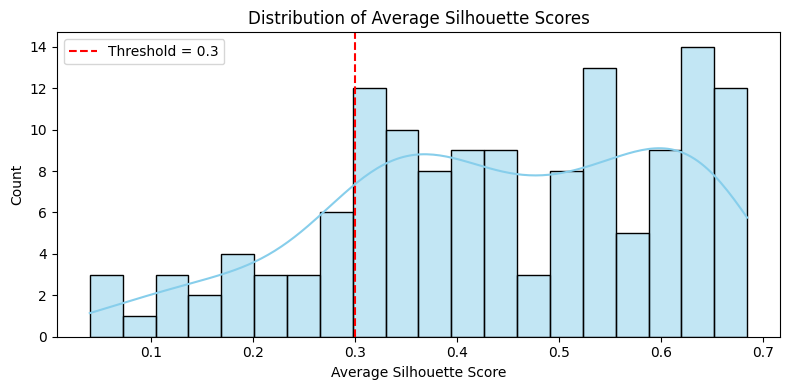

In [ ]:
# Silhouette Distribution Plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.histplot(df['Average_Silhouette'], kde=True, bins=20, color="skyblue")
plt.axvline(silhouette_threshold, color='red', linestyle='--', label=f'Threshold = {silhouette_threshold}')
plt.title("Distribution of Average Silhouette Scores")
plt.xlabel("Average Silhouette Score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("average_silhouette_distribution.png", dpi=600)
plt.show()